In [1]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/SeparableNNs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 1.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np

experiment,sys,dim = "NN","TodaLatticeNADeep",6
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-np.exp(x[0]-x[1])+np.exp(x[2]-x[0]),
                           -np.exp(x[1]-x[2])+np.exp(x[0]-x[1]),
                           -np.exp(x[2]-x[0])+np.exp(x[1]-x[2]),])
H = lambda x: 0.5*(x[3]**2+x[4]**2+x[5]**2)+np.exp(x[0]-x[1])+np.exp(x[1]-x[2])+np.exp(x[2]-x[0])-3

spacedim = [(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)] # by using this spacedim, x<1 therefore x**2<1. the hamiltonian will usually be negative.
h= 0.01
x0, H0 = 0.,0.
initialcon = [64, 128, 256, 512, 1024, 2048] #, 4096, 8192
LR=0.01

"""# Test dataset creation"""

from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import time 

# xxshort,yyshort = np.linspace(spacedim[0][0], spacedim[0][1], 20), np.linspace(spacedim[1][0], spacedim[1][1], 20)
# xshort,yshort = np.meshgrid(xxshort,yyshort)

# H_true = H(np.c_[np.ravel(xshort),np.ravel(yshort)].transpose())
# sample_points = np.expand_dims(np.c_[np.ravel(xshort),np.ravel(yshort)],2)

# def get_H_grad(model, z,device):
#     inputs=torch.unsqueeze(Variable(torch.tensor([z[0][0],z[1][0]]), requires_grad = True),0).to(device)
#     out=model(inputs.float())
#     dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True, allow_unused=True)[0].detach().cpu().numpy()
#     return out.detach().cpu().numpy(), dH[0][1],-dH[0][0] # negative dH/dq is dp/dt

In [4]:
# NN takes in p, q, dq, dp, and learns the Hamiltonian. The derivative of the Hamiltonian is used for integration

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.prune as prune
import numpy as np
import os
import time
from tqdm import tqdm
import math

# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

from sklearn.model_selection import train_test_split


# class sepNet(nn.Module):

#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(sepNet , self).__init__()
#         self.mask1 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(input_size/2))),torch.zeros((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1),
#             torch.squeeze(torch.cat((torch.zeros((1,int(input_size/2))),torch.ones((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1)),0)
#         self.mask2 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size1))),torch.zeros((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size1))),torch.ones((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1)),0)
#         self.mask3 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size2))),torch.zeros((1,int(hidden_size2)))),1),0).repeat(int(output_size),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size2))),torch.ones((1,int(hidden_size2)))),1),0).repeat(int(output_size),1)),0)
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size1*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_1.weight.mul_(self.mask1)
#         self.hidden_layer_2 = nn.Linear( hidden_size1*2, hidden_size2*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_2.weight.mul_(self.mask2)
#         self.output_layer = nn.Linear( hidden_size2*2, output_size*2 , bias=True)
#         with torch.no_grad():
#             self.output_layer.weight.mul_(self.mask3)
#         prune.custom_from_mask(self.hidden_layer_1, name='weight', mask=self.mask1)
#         prune.custom_from_mask(self.hidden_layer_2, name='weight', mask=self.mask2)
#         prune.custom_from_mask(self.output_layer, name='weight', mask=self.mask3)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)
#         return x


# PINN
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.hidden_layer_3 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.hidden_layer_4 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = softplus(self.hidden_layer_3(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = softplus(self.hidden_layer_4(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

# class SumNet(nn.Module):

#     def __init__(self, input_size, hidden_size, output_size):
#         super(SumNet , self).__init__()
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
#         self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
#         self.output_layer = nn.Linear( hidden_size, 2 , bias=True)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)

#         return x

# calculate loss
def lossfuc(model,mat,x,y,device,x0,H0,dim,c1=1,c2=1,c3=1,c4=1,verbose=False):
    dim = int(wholemat.shape[1]/2)
    f3=(model(torch.tensor([[x0]*dim]).to(device))-torch.tensor([[H0]]).to(device))**2
    dH=torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1),create_graph=True, allow_unused=True)[0]
    dHdq=dH[:,:int(dim/2)]
    dHdp=dH[:,int(dim/2):]
    qprime=(mat[:,dim:int(3*dim/2)])
    pprime=(mat[:,int(3*dim/2):])
    assert dHdq.shape[1] == int(dim/2)
    assert dHdp.shape[1] == int(dim/2)
    assert qprime.shape[1] == int(dim/2)
    assert pprime.shape[1] == int(dim/2)
    f1=torch.mean((dHdp-qprime)**2,dim=0)
    # print(dHdq, pprime)
    f2=torch.mean((dHdq+pprime)**2,dim=0)
    f4=torch.mean((dHdq*qprime+dHdp*pprime)**2,dim=0)
    loss=torch.mean(c1*f1+c2*f2+c3*f3+c4*f4)
    if loss > 1000: print("errors:", f1, f2, f3, f4)
    meanf1,meanf2,meanf3,meanf4=torch.mean(c1*f1),torch.mean(c2*f2),torch.mean(c3*f3),torch.mean(c4*f4)
    if verbose:
      print(x)
      print(meanf1,meanf2,meanf3,meanf4)
      print(loss,meanf1,meanf2,meanf3,meanf4)
    return loss,meanf1,meanf2,meanf3,meanf4


def data_preprocessing(start_train, final_train,device):       
    # wholemat=[]
    # for i in range(len(start_train[0,:])):
    #     wholemat.append(np.vstack((
    #         np.hstack((start_train[:,i], (final_train[:,i]-start_train[:,i])/h)),
    #         np.hstack((final_train[:,i], (final_train[:,i]-start_train[:,i])/h)))))
    wholemat = np.hstack((start_train.transpose(), final_train.transpose()))

    wholemat =torch.tensor(wholemat)
    wholemat=wholemat.to(device)

    wholemat,evalmat=train_test_split(wholemat, train_size=0.8, random_state=1)

    return wholemat,evalmat

## train

# evaluate loss of dataset 
def get_loss(model,device,initial_conditions,bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4,trainset=False,verbose=False):
    # this function is used to calculate average loss of a whole dataset
    # rootpath: path of set to be calculated loss
    # model: model
    # trainset: is training set or not


    if trainset:
        mat=wholemat
    else:
        mat=evalmat
    avg_loss=0
    avg_f1=0
    avg_f2=0
    avg_f3=0
    avg_f4=0
    for count in range(0,len(mat),bs):
      curmat=mat[count:count+bs]
      x=Variable((curmat[:,:dim]).float(),requires_grad=True)
      y=model(x)
      x=x.to(device)
      loss,f1,f2,f3,f4=lossfuc(model,curmat,x,y,device,x0,H0,dim,c1,c2,c3,c4)
      avg_loss+=loss.detach().cpu().item()
      avg_f1+=f1.detach().cpu().item()
      avg_f2+=f2.detach().cpu().item()
      avg_f3+=f3.detach().cpu().item()
      avg_f4+=f4.detach().cpu().item()
    num_batches=len(mat)//bs
    avg_loss/=num_batches
    avg_f1/=num_batches
    avg_f2/=num_batches
    avg_f3/=num_batches
    avg_f4/=num_batches
    if verbose:
        print(' loss=',avg_loss,' f1=',avg_f1,' f2=',avg_f2,' f3=',avg_f3,' f4=',avg_f4)
    return avg_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if abs(self.counter-self.patience)<5:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'checkpoint.pt')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def train(net,bs,num_epoch,initial_conditions,device,wholemat,evalmat,x0,H0,dim,LR,patience,c1,c2,c3,c4):
    # function of training process
    # net: the model
    # bs: batch size 
    # num_epoch: max of epoch to run
    # initial_conditions: number of trajectory in train set
    # patience: EarlyStopping parameter
    # c1~c4: hyperparameter for loss function


    avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li=[],[],[],[],[]
    avg_vallosses=[]
    
    start = time.time()
    lr = LR # initial learning rate
    net=net.to(device)

    early_stopping = EarlyStopping(patience=patience, verbose=False,delta=0.00001) # delta
    optimizer=torch.optim.Adam(net.parameters() , lr=lr )
    for epoch in range(num_epoch):

        running_loss=0

        running_f1=0
        running_f2=0
        running_f3=0
        running_f4=0
        num_batches=0
        
        # train
        shuffled_indices=torch.randperm(len(wholemat))
        net.train()
        for count in range(0,len(wholemat),bs):
            optimizer.zero_grad()

            indices=shuffled_indices[count:count+bs]
            mat=wholemat[indices]

            x=Variable(torch.tensor(mat[:,:dim]).float(),requires_grad=True)
            y=net(x)

            loss,f1,f2,f3,f4=lossfuc(net,mat,x,y,device,x0,H0,dim,c1,c2,c3,c4)  
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 1)

            optimizer.step()

            # compute some stats
            running_loss += loss.detach().item()
            running_f1 += f1.detach().item()
            running_f2 += f2.detach().item()
            running_f3 += f3.detach().item()
            running_f4 += f4.detach().item()

            num_batches+=1
            torch.cuda.empty_cache()



        avg_loss = running_loss/num_batches
        avg_f1 = running_f1/num_batches
        avg_f2 = running_f2/num_batches
        avg_f3 = running_f3/num_batches
        avg_f4 = running_f4/num_batches
        elapsed_time = time.time() - start
        
        avg_lossli.append(avg_loss)
        avg_f1li.append(avg_f1)
        avg_f2li.append(avg_f2)
        avg_f3li.append(avg_f3)
        avg_f4li.append(avg_f4)
        
        
        # evaluate
        net.eval()
        avg_val_loss=get_loss(net,device,len(evalmat),bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4)
        avg_vallosses.append(avg_val_loss)
        
        if epoch % 100 == 0 : 
            print(' ')
            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', avg_loss ,' val_loss=',avg_val_loss,' f1=', avg_f1 ,' f2=', avg_f2 ,
                  ' f3=', avg_f3 ,' f4=', avg_f4 , 'num_batches=', num_batches, 'percent lr=', optimizer.param_groups[0]["lr"] )
        
        
        
        early_stopping(avg_val_loss,net)
        if early_stopping.early_stop:
            print('Early Stopping')
            break
            
    net=torch.load('checkpoint.pt')
    return net,epoch,avg_vallosses,avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li

class splitBalancedLinear(nn.Module):

    def __init__(self, input_size, output_size):
        # output_size is the size of one of the two parallel networks
        super(splitBalancedLinear , self).__init__()
        self.input_size, self.output_size = input_size, output_size
        weights = torch.Tensor(2,self.input_size,self.output_size)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(2,1,self.output_size)
        self.bias = nn.Parameter(bias)

        # initialise weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, x):
        # print(self.weights, self.bias)
        # print("mul", torch.einsum('ijk,ikl->ijl', x, self.weights))
        # print("add", torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias))
        return torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias)
        # return F.linear(x, self.weights, self.bias)

class sepNet(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(sepNet , self).__init__()
        self.hidden_layer_1 = splitBalancedLinear(input_size, hidden_size1)
        self.hidden_layer_2 = splitBalancedLinear(hidden_size1, hidden_size2)
        self.hidden_layer_3 = splitBalancedLinear(hidden_size2, hidden_size2)
        self.hidden_layer_4 = splitBalancedLinear(hidden_size2, hidden_size2)
        self.output_layer = splitBalancedLinear(hidden_size2, output_size)
        
    def forward(self, x):
        # print("input", x.shape)
        # print(x)
        x = torch.stack((x[:,:int(x.shape[-1]/2)],x[:,int(x.shape[-1]/2):]))
        # print(x)
        # print("initial", x.shape)
        x = softplus(self.hidden_layer_1(x)) 
        # print(x)
        # print("hl1", x.shape)
        x = softplus(self.hidden_layer_2(x)) 
        x = softplus(self.hidden_layer_3(x)) 
        x = softplus(self.hidden_layer_4(x)) 
        # print(x)
        # print("hl2", x.shape)
        x = self.output_layer(x)
        # print(x)
        # print("output", x.shape)
        x = torch.sum(x)
        return x

In [6]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics

for i in range(20):
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/h

    # delta2 = delta.copy()
    # delta2[0,:] = f1(start)
    # delta2[1,:] = f2(start)
    # dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    # dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    # data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = sepNet(3,22,22,1) #sepnet = sepNet(3,22,22,1)
    starttime = time.time() 
    print("training sepNet")

    results = train(sepnet,bs=min(int(len(wholemat)/5), 128),num_epoch=7000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    # results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(sepnet, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
    # file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = Net(6,31,1)
    starttime = time.time() 
    print("training PINN Net")
    
    results = train(net,bs=min(int(len(wholemat)/5), 128),num_epoch=7000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(net, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a')
    # file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    # print(septraintime, PINNtraintime)

training sepNet
 
epoch= 0  time= 0.036446571350097656  loss= 0.7351988856117208  val_loss= 1.8154738674774786  f1= 0.09275449142588293  f2= 0.5261655253009948  f3= 0.11627886878947417  f4= 9.536887715627115e-11 num_batches= 6 percent lr= 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:262: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:267: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
epoch= 1200  time= 106.30248093605042  loss= 0.00011088928633869576  val_loss= 0.00012438008851729153  f1= 2.197162203347427e-05  f2= 4.190083965715376e-05  f3= 9.06202747221239e-06  f4= 3.795479717585535e-05 num_batches= 13 percent lr= 0.01
 
epoch= 1300  time= 115.05874228477478  loss= 0.00011517668274849288  val_loss= 0.00013309619704702562  f1= 2.4456599082486965e-05  f2= 4.213705236937931e-05  f3= 9.942110363698912e-06  f4= 3.864092093292772e-05 num_batches= 13 percent lr= 0.01
 
epoch= 1400  time= 123.70429277420044  loss= 0.0002289420134469447  val_loss= 0.00021014989698048695  f1= 4.605376832542937e-05  f2= 5.953347410457612e-05  f3= 6.986753019716092e-05  f4= 5.348724081977826e-05 num_batches= 13 percent lr= 0.01
 
epoch= 1500  time= 132.7421669960022  loss= 0.0001528428072126589  val_loss= 0.00017143420736681676  f1= 2.375485122756955e-05  f2= 8.293818416432098e-05  f3= 2.6797708366862375e-06  f4= 4.3470000984082115e-05 num_b

In [ ]:
# n_sample = 20
# dim = 6

# z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
#                                       np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
#                                       np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
#                                       ))).reshape(6, n_sample**dim).transpose(1,0)
# for i in tqdm(range(dim**2)):
#   np.savetxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/test%s.txt' %(sys,i), z[n_sample**4*i:n_sample**4*(i+1), :])

100%|██████████| 36/36 [00:50<00:00,  1.42s/it]


In [7]:
from tqdm import tqdm

n_sample = 20 # 6

sepnet_total, net_total = [],[]
for seed in tqdm(range(20)):
  for ini in initialcon:
    net = Net(6,31,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    sepnet = sepNet(3,22,22,1) #PINN.sepNet(2,11,11,1)
    sepnet.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini)))

    def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5],
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2], ]) # negative dH/dq is dp/dt
      # return np.asarray([dH.detach().to(device).numpy()[:,3], dH.detach().to(device).numpy()[:,4], dH.detach().to(device).numpy()[:,5],
      #               -dH.detach().to(device).numpy()[:,0], -dH.detach().to(device).numpy()[:,1], -dH.detach().to(device).numpy()[:,2], ]) # negative dH/dq is dp/dt

    
    f1 = lambda x: np.stack([x[:,3], x[:,4], x[:,5]])
    f2 = lambda x: np.stack([-np.exp(x[:,0]-x[:,1])+np.exp(x[:,2]-x[:,0]),
                              -np.exp(x[:,1]-x[:,2])+np.exp(x[:,0]-x[:,1]),
                              -np.exp(x[:,2]-x[:,0])+np.exp(x[:,1]-x[:,2]),])

    fvec = lambda z: np.concatenate([f1(z), f2(z)])
    error = lambda x,y: np.sum(np.sqrt(np.sum((x-y)**2,0))/np.sqrt(np.sum(x**2,0))) # where x is the true vector and y is the approximated vector

    # z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
    #                                   np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
    #                                   np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
    #                                   ))).reshape(6, n_sample**dim).transpose(1,0)
    

    sepnet_error, net_error = 0, 0
    for i in range(6**2):
      inpz = torch.tensor(np.loadtxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/TodaLatticeNA/test%s.txt' %(i)))
      sepnet_error += error(fvec(inpz), get_grad(sepnet, inpz, 'cpu'))
      net_error += error(fvec(inpz), get_grad(net, inpz, 'cpu'))
    sepnet_total.append(sepnet_error)
    net_total.append(net_error)
    print(ini, net_error, sepnet_error)

  0%|          | 0/20 [00:00<?, ?it/s]

64 136048.5825606644 88372.56340314874
128 88186.05989634745 45190.90463807178
256 66534.46057306435 54899.88191629444
512 52015.02202759551 33462.58358671207
1024 42144.87199774863 23647.340430701657


  5%|▌         | 1/20 [09:49<3:06:48, 589.92s/it]

2048 40993.85417391457 33417.321880020245
64 176469.89806874184 157955.29242119045
128 111644.0543276599 54384.24054212354
256 89475.03420451768 55580.36782071079
512 56512.15644063647 52629.67297252952
1024 43531.314895303476 40133.068157059344


 10%|█         | 2/20 [19:53<2:59:22, 597.94s/it]

2048 48678.51871807198 31131.514585537312
64 228997.48256574082 152121.3045967272
128 125438.15187351832 80870.08674674343
256 99786.7334747915 50581.20553387507
512 58730.35985674465 39619.86598995904
1024 45405.44846952025 23924.37497597529


 15%|█▌        | 3/20 [30:12<2:52:06, 607.42s/it]

2048 41002.75674160243 21756.715894394358
64 338645.5312238365 102410.57296003366
128 93230.80064360808 66284.14811187424
256 70884.22026149531 47957.19588391936
512 55955.05946495622 40286.43497345289
1024 41314.956564905646 25319.565733383577


 20%|██        | 4/20 [40:34<2:43:35, 613.44s/it]

2048 40708.03420180979 29668.759695295197
64 241690.1449002311 210634.33112804807
128 97649.49182111109 60606.732946139615
256 98337.70951547692 83361.7745501314
512 50761.377751681284 31190.166602970396
1024 39340.5567409337 21206.24259495576


 25%|██▌       | 5/20 [50:58<2:34:17, 617.17s/it]

2048 42082.00067829642 27948.074798757563
64 130159.76001414661 85623.52351191499
128 87920.60849336868 79691.66845656386
256 82025.40412183649 44898.18459961143
512 67910.65012830464 47908.19750948801
1024 47163.470889278855 5219765.289832036


 30%|███       | 6/20 [1:01:47<2:26:29, 627.85s/it]

2048 46638.06018289382 nan
64 150114.9630172823 169974.96975001192
128 119847.26297416247 68687.56720329128
256 66910.1722171002 71296.26049652268
512 54279.13336144108 35541.932178528645
1024 49999.164779232175 36896.84850006454


 35%|███▌      | 7/20 [1:12:16<2:16:09, 628.42s/it]

2048 39492.0622612766 28219.40700743882
64 192472.2177407535 160536.7057436752
128 113792.99569330503 62624.91993703487
256 109854.51547451079 83106.08615318801
512 59499.20538330106 53684.49388717252
1024 41927.020860172015 32028.983261402063


 40%|████      | 8/20 [1:22:43<2:05:35, 627.98s/it]

2048 41082.058904453384 32673.304557734453
64 190357.02761452715 120434.99578061231
128 111336.0384639038 86244.5656487201
256 72380.95682521642 47069.261003360254
512 62364.31017480248 51894.952655035115
1024 47580.91747441304 35305.894809175195


 45%|████▌     | 9/20 [1:33:24<1:55:50, 631.88s/it]

2048 36631.09071301436 34758.293024417806
64 175708.86554430396 4655463.328397168
128 156088.94506496823 4549774.299813792
256 93109.5043406966 59914.27108855192
512 78156.73549462296 31543.71604874423
1024 56185.810697101224 38230.09549789645


 50%|█████     | 10/20 [1:44:17<1:46:25, 638.51s/it]

2048 34468.28288715948 34223.58630724712
64 204518.38022816178 168251.6578718369
128 98312.30222177737 77183.60824105887
256 93771.20307219327 5238715.058271764
512 62846.846466410534 41433.951635144265
1024 43430.18810268704 36518.89624724827


 55%|█████▌    | 11/20 [1:55:08<1:36:20, 642.26s/it]

2048 37876.24698385541 29004.315380369837
64 227731.26652915688 165360.8740011596
128 116224.35882289305 76119.95325062731
256 67854.30205218434 53288.251640630275
512 47343.43197361226 42405.514276710215
1024 53571.03106589678 29434.37031599576


 60%|██████    | 12/20 [2:05:57<1:25:55, 644.38s/it]

2048 37565.3076593831 24606.6354539249
64 185203.96542453163 189920.59485012936
128 98076.90188714433 64969.03291702781
256 82826.631042054 45201.47809224001
512 68655.78735957602 43071.39853129923
1024 52262.109805583736 26156.116207253828


 65%|██████▌   | 13/20 [2:16:46<1:15:20, 645.74s/it]

2048 35217.15362907041 31374.698430866483
64 220716.46619079806 123561.19192480408
128 95593.57574346109 124596.18774162188
256 72923.08724006917 59151.09105950366
512 64037.16134376663 37308.32366380645
1024 40720.23745496747 35038.36585367289


 70%|███████   | 14/20 [2:27:33<1:04:36, 646.01s/it]

2048 37675.25665773254 33238.127184569676
64 199722.47971589785 4202257.701898652
128 117980.01071929294 158773.79521350245
256 73139.08823939924 63178.68278155113
512 60786.82656325496 51076.46571721236
1024 46373.76835565491 32714.977117993807


 75%|███████▌  | 15/20 [2:38:18<53:48, 645.72s/it]  

2048 36314.73263046862 27241.437161004014
64 344616.07256873656 311698.1069548802
128 168203.0052766427 4403097.61241204
256 111722.88181877475 5238731.857527507
512 60174.24465214845 44052.16228709672
1024 46507.25001346643 30898.86650889009


 80%|████████  | 16/20 [2:49:05<43:05, 646.26s/it]

2048 34468.36391962467 32306.79098784847
64 222798.63118711676 214536.53122204187
128 98269.13139362415 73295.58242922375
256 95420.98951504813 55656.08081823052
512 73682.3873021815 51973.99325306583
1024 45998.79685292001 35133.970847178265


 85%|████████▌ | 17/20 [2:59:52<32:19, 646.56s/it]

2048 37774.7873242916 33155.654229591295
64 229022.68349947585 112109.91604791507
128 104492.32557065353 56695.25361003173
256 85727.94432873768 51541.729163136224
512 66699.47759632143 41065.030794290884
1024 49276.7286374024 33767.875022189335


 90%|█████████ | 18/20 [3:10:42<21:35, 647.57s/it]

2048 45129.24179095317 26273.84213220405
64 135234.8314749759 120713.99764203913
128 139582.85049393628 124630.73343217088
256 76144.51250781903 60984.97461289192
512 61299.424719296614 37624.20916972436
1024 39266.69681339765 25310.200637144935


 95%|█████████▌| 19/20 [3:21:26<10:46, 646.40s/it]

2048 46381.85796068393 28664.207298200243
64 254512.83845128576 217496.83549710683
128 126504.35130822945 78775.32046718015
256 68568.21214966285 39476.901046945946
512 55345.32288350017 41101.549549099684
1024 49171.99931432007 25393.400162306425


100%|██████████| 20/20 [3:32:07<00:00, 636.38s/it]

2048 38352.67750937423 29034.049114572812


In [8]:
sepnet_total, net_total = [np.mean(sepnet_total[i::len(initialcon)]) for i in range(len(initialcon))], [np.mean(net_total[i::len(initialcon)]) for i in range(len(initialcon))]

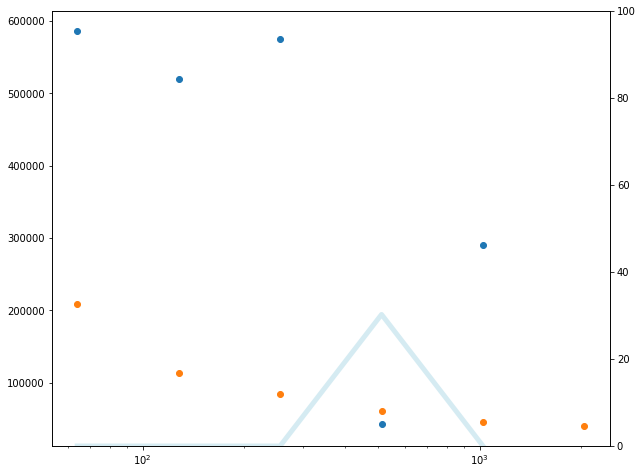

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error")
l2 = ax.scatter(initialcon, net_total, label = "net absolute error")
# ax.set_ylabel('absolute error')
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage error reduction")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

In [10]:
sepnet_total, net_total

([586471.7497801548,
  519624.81068794196,
  575229.5297030283,
  42443.73076410212,
  290341.2371356262,
  nan],
 [209237.10442601825,
  113418.66113448041,
  83869.87814873244,
  60852.74604720775,
  46058.616989245274,
  39926.61727639653])

In [ ]:
# import matplotlib.pyplot as plt
# from torch.autograd import Variable
# from matplotlib import cm
# from understandingPINNs.models import PINN
# import torch
# from understandingPINNs import metrics

# for i in range(20):
#   seed = i
#   np.random.seed(seed=seed)
#   for ini in initialcon: 

#     start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

#     delta = (final-start)/0.1
#     delta2 = delta.copy()
#     delta2[0,:] = f1(start)
#     delta2[1,:] = f2(start)
#     dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
#     dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
#     data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

#     """# sumNN"""

    

#     if torch.cuda.is_available():
#       device=torch.device('cuda')
#     else:
#       device=torch.device('cpu')
#     print("device used", device)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

#     import torch.optim as optim
#     import time 


#     sumnet = PINN.SumNet(2,16,2)
#     starttime = time.time() 

#     results = PINN.train(sumnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
#     sumnet, epochs = results[0], results[1]
#     septraintime = time.time()-starttime
#     torch.save(sumnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.pt' %(sys,sys,"sumNN",seed,ini))

#     H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
#     for i in tqdm(range(len(sample_points))):
#       out = get_H_grad(sumnet, sample_points[i], device)
#       H_pred[i] = out[0]
#       dq_pred[i] = out[1]
#       dp_pred[i] = out[2]
#     print(H_pred.shape, dq_pred.shape, dp_pred.shape)
#     file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
#     file_object.write('sumNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
#           %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
#           np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
#           np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
#     file_object.close()
    
#     H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

#     plt.figure(figsize = (10,10))
#     plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
#     plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
#     plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sumNN"))

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from understandingPINNs.models import PINN
import torch
from understandingPINNs import metrics

for i in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajSympEuler(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/0.1
    delta2 = delta.copy()
    delta2[0,:] = f1(start)
    delta2[1,:] = f2(start)
    dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = PINN.sepNet(1,11,11,1)
    starttime = time.time() 

    results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(sepnet, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a') 
    file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = PINN.Net(2,16,1)
    starttime = time.time() 
    
    results = PINN.train(net,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(net, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a')
    file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    print(septraintime, PINNtraintime)